Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Section 12.7.3

Temperature estimation given the day of the year and the hour of the day using regression trees. This is a toy problem (although it uses real temperature data from Manhattan, Kansas), which requires nonlinear estimation\
Topics and relevant videos: [Regression](https://www.youtube.com/watch?v=9ugdj-kLGCI), [bagging, random forests, boosting](https://www.youtube.com/watch?v=UsiAHF6ZdNE)

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from os import listdir
from scipy import stats
import datetime as dt
import random
import urllib.request
import io

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

In [2]:
# file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"
# file_name_temperature_2016 = "../data/weather/temperatures_2016.npy"
# file_name_times_2015 = "../data/weather/times_2015.npy"
# file_name_times_2016 = "../data/weather/times_2016.npy"
# file_name_dates_2015 = "../data/weather/dates_2015.npy"
# file_name_dates_2016 = "../data/weather/dates_2016.npy"

# data_matrix_2015 = np.load(file_name_temperature_2015)
# data_matrix_2016 = np.load(file_name_temperature_2016)
# time_matrix_2015 = np.load(file_name_times_2015)
# time_matrix_2016 = np.load(file_name_times_2016)
# date_matrix_2015 = np.load(file_name_dates_2015)
# date_matrix_2016 = np.load(file_name_dates_2016)

# Raw GitHub URLs
url_temperature_2015 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/temperatures_2015.npy"
url_temperature_2016 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/temperatures_2016.npy"
url_times_2015 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/times_2015.npy"
url_times_2016 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/times_2016.npy"
url_dates_2015 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/dates_2015.npy"
url_dates_2016 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/dates_2016.npy"

# Load .npy files using BytesIO
with urllib.request.urlopen(url_temperature_2015) as response:
    data_matrix_2015 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_temperature_2016) as response:
    data_matrix_2016 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_times_2015) as response:
    time_matrix_2015 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_times_2016) as response:
    time_matrix_2016 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_dates_2015) as response:
    date_matrix_2015 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_dates_2016) as response:
    date_matrix_2016 = np.load(io.BytesIO(response.read()))

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [3]:
station = 52 
name = process_name(file_name_list[station]) 
print(name)

Manhattan, KS


In [4]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("Entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
temperature_2015 = remove_faulty_measurements(data_matrix_2015[:,station],verbose)
n_2015 = len(temperature_2015)
temperature_2016 = remove_faulty_measurements(data_matrix_2016[:,station],verbose)
n_2016 = len(temperature_2016)

In [5]:
hour_2015 = (time_matrix_2015[:,station]/100).astype(int)
hour_2016 = (time_matrix_2016[:,station]/100).astype(int)

day_2015 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2015[:,station]])
day_2016 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2016[:,station]])

n_data_366 = np.sum(day_2016==366)
temperature_2016 = temperature_2016[:-n_data_366]
day_2016 = day_2016[:-n_data_366]
hour_2016 = hour_2016[:-n_data_366]

In [6]:
n_days = 365
n_hours = 24

temperature_grid_2015 = np.zeros((n_hours,n_days))
temperature_grid_2016 = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        temperature_grid_2015[h,m-1] = np.mean(temperature_2015[(hour_2015 == h) & (day_2015 == m)])
        temperature_grid_2016[h,m-1] = np.mean(temperature_2016[(hour_2016 == h) & (day_2016 == m)])
max_mean_temp_2015 = np.max(temperature_grid_2015)
max_mean_temp_2016 = np.max(temperature_grid_2016)
max_mean_temp = np.max(np.array([max_mean_temp_2015,max_mean_temp_2016]))
min_mean_temp_2015 = np.min(temperature_grid_2015)
min_mean_temp_2016 = np.min(temperature_grid_2016)
min_mean_temp = np.min(np.array([min_mean_temp_2015,min_mean_temp_2016]))

In [7]:
# Returns indices corresponding to region r
def inds_region(r,day,hour):
    return ( (day >= r["day_lims"][0]) & (day <= r["day_lims"][1]) 
                             & (hour >= r["hour_lims"][0]) & (hour <= r["hour_lims"][1]) )

# Returns the estimate corresponding to a tree 
def tree_estimate(regions,temperature,day,hour,verbose=False):
    err_2015 = 0
    err_2016 = 0
    n_regions = len(regions)
    estimate_grid = np.zeros((n_hours,n_days))
    for ind_r,r in enumerate(regions):
        inds_r = inds_region(r,day,hour)
        temp_region = temperature[inds_r]
        est_region = np.mean(temp_region)
        estimate_grid[r["hour_lims"][0]:(r["hour_lims"][1]+1),(r["day_lims"][0]-1):r["day_lims"][1]] = est_region
    return estimate_grid

In [8]:
# Given a set of possible thresholds for a feature, this function computes the residual sum of squares of the tree estimator 
# within that region for each of the possible thresholds
def find_split(feature,data,possible_thresholds, verbose=True):
    err_vals = np.zeros(len(possible_thresholds))
    best_thresh = 0
    best_err = -1
    for ind,thresh in enumerate(possible_thresholds):
        left_split = data[feature < thresh]
        right_split = data[feature >= thresh]
        if right_split.size > 0:
            estimate_right_split = np.mean(right_split)
            if left_split.size >0:
                estimate_left_split = np.mean(left_split)
                err_vals[ind] = np.sum((left_split-estimate_left_split)**2) + np.sum((right_split-estimate_right_split)**2)
            else:
                err_vals[ind] = np.sum((right_split-estimate_right_split)**2)
            if verbose:
                print(thresh)
                print("left split: ",len(left_split))
                print("right split: ",len(right_split))
                if len(left_split)>0:
                    print("estimate left split: ",estimate_left_split)
                print("estimate right split: ",estimate_right_split)
                print("squared error: ",err_vals[ind])
    return err_vals

In [9]:
def recursive_binary_splitting(temperature,day,hour,n_splits,randomize=False,n_rand=8,verbose=False,find_split_verbose=False):
    first_region = {
      "day_lims": [1,n_days],
      "hour_lims": [0,n_hours-1]
    }
    regions = [first_region]

    if verbose:
        print("First region")
        print("Estimate",np.mean(temperature))

    for ind_splits in range(n_splits):

        if verbose:
            print("Split",ind_splits+1)

        split_region_ind = -1
        split_feature = ""
        split_thresh = -1
        best_err_decrease = 0

        for ind_r,r in enumerate(regions):

            inds_r = inds_region(r,day,hour)
            temp_r = temperature[inds_r]
            day_r = day[inds_r]
            hour_r = hour[inds_r]
            err_region = np.sum((temp_r-np.mean(temp_r))**2)
            random_choice = random.randint(0,n_rand-1)
            # In random forest the feature may be randomly chosen
            if randomize and random_choice < 2:
                if random_choice == 0:
                    feature = "day"
                    possible_thresholds_day = np.arange(r["day_lims"][0],r["day_lims"][1]+1)
                    err_day = find_split(day_r,temp_r,possible_thresholds_day,find_split_verbose)
                    best_err_day_ind = np.argmin(err_day)
                    best_err_day = err_day[best_err_day_ind]
                    thresh = possible_thresholds_day[best_err_day_ind]
                    err_decrease = err_region-best_err_day
                else:
                    feature = "hour"
                    possible_thresholds_hour = np.arange(r["hour_lims"][0],r["hour_lims"][1]+1)
                    err_hour = find_split(hour_r,temp_r,possible_thresholds_hour,find_split_verbose)
                    best_err_hour_ind = np.argmin(err_hour)
                    best_err_hour = err_hour[best_err_hour_ind]
                    thresh = possible_thresholds_hour[best_err_hour_ind]
                    err_decrease = err_region-best_err_hour
            else:
                possible_thresholds_day = np.arange(r["day_lims"][0],r["day_lims"][1]+1)
                err_day = find_split(day_r,temp_r,possible_thresholds_day,find_split_verbose)
                best_err_day_ind = np.argmin(err_day)
                best_err_day = err_day[best_err_day_ind]
                possible_thresholds_hour = np.arange(r["hour_lims"][0],r["hour_lims"][1]+1)
                err_hour = find_split(hour_r,temp_r,possible_thresholds_hour,find_split_verbose)
                best_err_hour_ind = np.argmin(err_hour)
                best_err_hour = err_hour[best_err_hour_ind]
                if best_err_day < best_err_hour:
                    feature = "day"
                    thresh = possible_thresholds_day[best_err_day_ind]
                    err_decrease = err_region-best_err_day
                else:
                    feature = "hour"
                    thresh = possible_thresholds_hour[best_err_hour_ind]
                    err_decrease = err_region-best_err_hour
                
            if split_region_ind == -1 or err_decrease > best_err_decrease:
                split_region_ind = ind_r
                split_feature = feature
                split_thresh = thresh
                best_err_decrease = err_decrease
            if verbose:
                print("Region to split",regions[split_region_ind])
                print("Feature",split_feature)
                print("Threshold",split_thresh)

        split_region = regions[split_region_ind]

        if split_feature == "day":

            day_lims_left = [split_region["day_lims"][0],split_thresh-1]
            hour_lims_left = split_region["hour_lims"]
            day_lims_right = [split_thresh,split_region["day_lims"][1]]
            hour_lims_right = split_region["hour_lims"]

        else:

            day_lims_left = split_region["day_lims"]
            hour_lims_left = [split_region["hour_lims"][0],split_thresh-1]
            day_lims_right = split_region["day_lims"]
            hour_lims_right = [split_thresh,split_region["hour_lims"][1]]        

        region_left = {
          "day_lims": day_lims_left,
          "hour_lims": hour_lims_left
        }
        region_right = {
          "day_lims": day_lims_right,
          "hour_lims": hour_lims_right
        }

        if verbose:
                print("New left region",region_left)
                est_left = np.mean(temperature_2015[inds_region(region_left,day,hour)])
                print("Estimate",est_left)
                print("New right region",region_right)  
                est_right = np.mean(temperature_2015[inds_region(region_right,day,hour)])
                print("Estimate",est_right)

        regions.pop(split_region_ind)
        regions.append(region_left)
        regions.append(region_right)
    return regions

In [10]:
# The error metric is the square root of the average residual sum of squares
def compute_error(estimate, temperature,day,hour):
    RSS = 0
    n = len(temperature)
    for ind in range(n):
        RSS += (temperature[ind] - estimate[hour[ind],day[ind]-1])**2
    root_RSS = np.sqrt(RSS/n)
    return root_RSS

In [11]:
# Bagging

n_2015 = len(temperature_2015)
n_bootstrap = 50
n_splits = 4
randomize = False
n_rand = 10

error_2015_bagging = np.zeros(n_bootstrap)
error_2016_bagging = np.zeros(n_bootstrap)
error_2015_bagging_individual = np.zeros(n_bootstrap)
error_2016_bagging_individual = np.zeros(n_bootstrap)

# Iterations that will be plotted
plot_inds = [0,3,6,8,14,26,31]
plot_trees_bagging = []
plot_bagging = []

for ind_b in range(n_bootstrap):
    
    random.seed(ind_b)
    bootstrap_inds = random.choices(np.arange(0,n_2015),k=n_2015)
    
    temp_b = temperature_2015[bootstrap_inds]
    hour_b = hour_2015[bootstrap_inds]
    day_b = day_2015[bootstrap_inds]

    verbose = False
    find_split_verbose=False
    regions_b = recursive_binary_splitting(temp_b,day_b,hour_b,n_splits,randomize,n_rand,verbose,find_split_verbose)
    save_str= ""
    estimate = tree_estimate(regions_b,temp_b,day_b,hour_b)
    if ind_b == 0:
        sum_trees = np.copy(estimate)
    else:
        sum_trees += estimate
    bagging_estimate = sum_trees / (ind_b + 1)
    error_2015_bagging[ind_b] = compute_error(bagging_estimate, temperature_2015,day_2015,hour_2015)
    error_2016_bagging[ind_b] = compute_error(bagging_estimate, temperature_2016,day_2016,hour_2016)
    error_2015_bagging_individual[ind_b] = compute_error(estimate, temperature_2015,day_2015,hour_2015)
    error_2016_bagging_individual[ind_b] = compute_error(estimate, temperature_2016,day_2016,hour_2016)
    if ind_b in plot_inds:
        plot_trees_bagging.append(estimate)
        plot_bagging.append(bagging_estimate)

In [12]:
# Random forest

randomize = True
n_rand = 10

error_2015_random_forest = np.zeros(n_bootstrap)
error_2016_random_forest = np.zeros(n_bootstrap)
error_2015_rf_individual = np.zeros(n_bootstrap)
error_2016_rf_individual = np.zeros(n_bootstrap)

verbose = False
find_split_verbose=False

plot_trees_random_forest = []
plot_random_forest = []

for ind_b in range(n_bootstrap):
    
    random.seed(ind_b)
    bootstrap_inds = random.choices(np.arange(0,n_2015),k=n_2015)
    
    temp_b = temperature_2015[bootstrap_inds]
    hour_b = hour_2015[bootstrap_inds]
    day_b = day_2015[bootstrap_inds]

    regions_b = recursive_binary_splitting(temp_b,day_b,hour_b,n_splits,randomize,n_rand,verbose,find_split_verbose)
    save_str= ""
    estimate = tree_estimate(regions_b,temp_b,day_b,hour_b)
    if ind_b == 0:
        sum_trees = np.copy(estimate)
    else:
        sum_trees += estimate
    random_forest_estimate = sum_trees / (ind_b + 1)
    error_2015_random_forest[ind_b] = compute_error(random_forest_estimate, temperature_2015,day_2015,hour_2015)
    error_2016_random_forest[ind_b] = compute_error(random_forest_estimate, temperature_2016,day_2016,hour_2016)
    error_2015_rf_individual[ind_b] = compute_error(estimate, temperature_2015,day_2015,hour_2015)
    error_2016_rf_individual[ind_b] = compute_error(estimate, temperature_2016,day_2016,hour_2016)

    if ind_b in plot_inds:
        plot_trees_random_forest.append(estimate)
        plot_random_forest.append(random_forest_estimate)

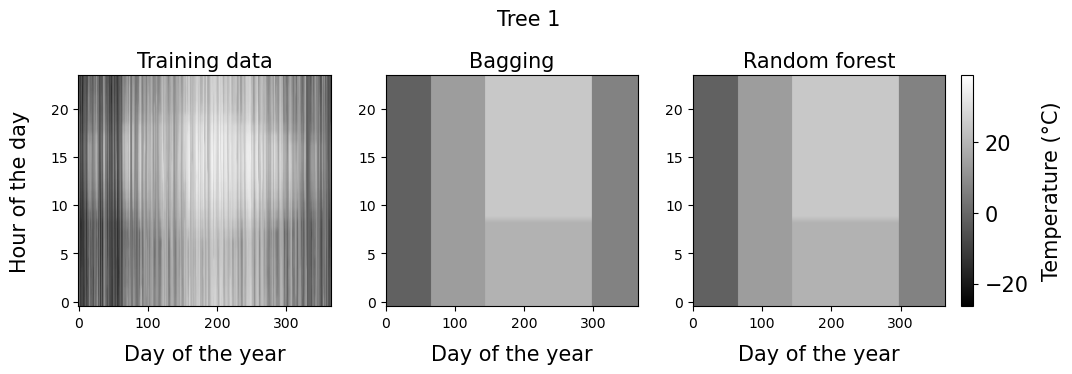

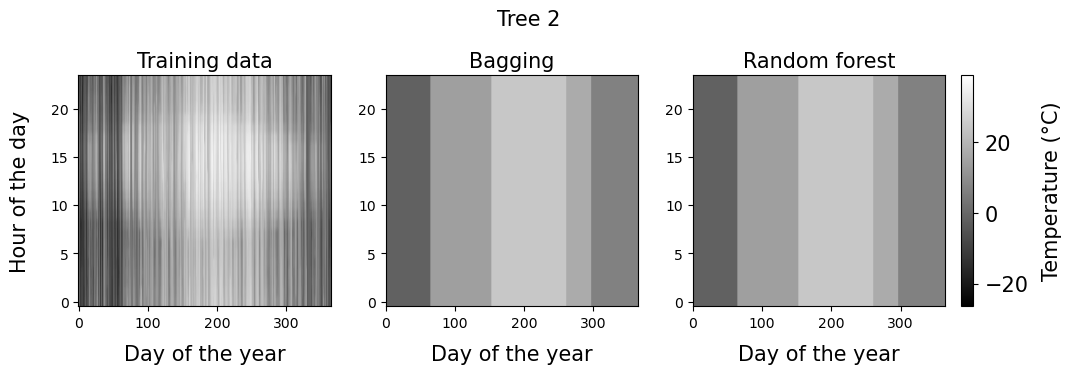

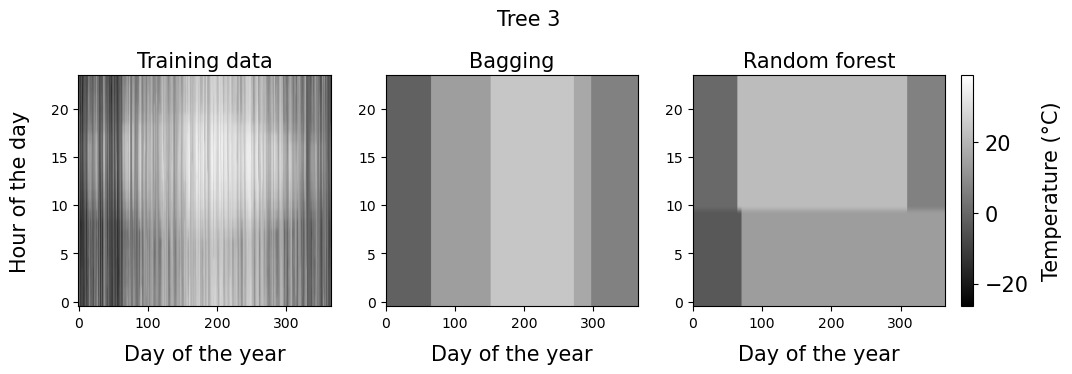

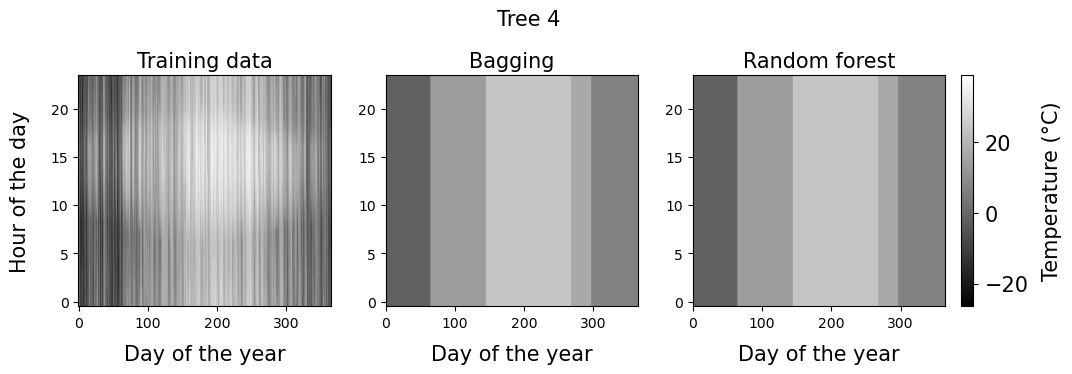

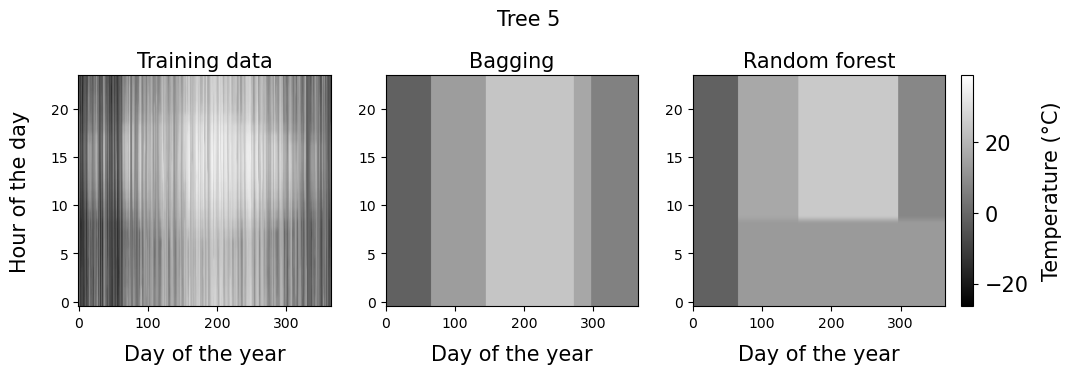

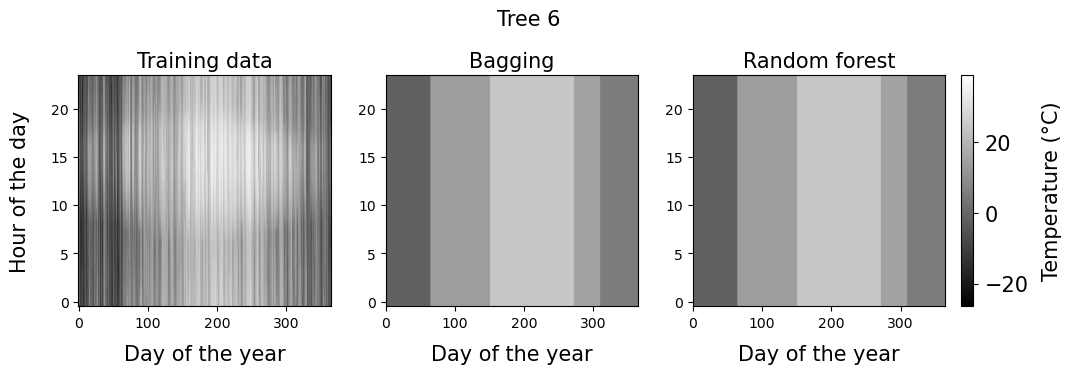

In [13]:
for ind in range(len(plot_inds)-1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),width_ratios=[3,3,3.75])

    fig.suptitle("Tree " + str(ind+1),fontsize=font_size,y = 1.1)
        
    im = ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
    ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
    ax1.set_ylim([0-0.5,n_hours-0.5])
    ax1.set_xlim([0-0.5,n_days-0.5])
    ax1.set_title("Training data",fontsize=font_size);

    im = ax2.imshow(plot_trees_bagging[ind], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
    ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax2.set_title("Bagging",fontsize=font_size);

    im = ax3.imshow(plot_trees_random_forest[ind], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
    ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax3.set_title("Random forest",fontsize=font_size);
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
    cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10);

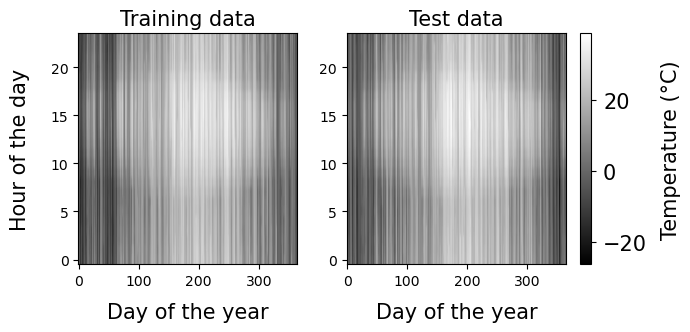

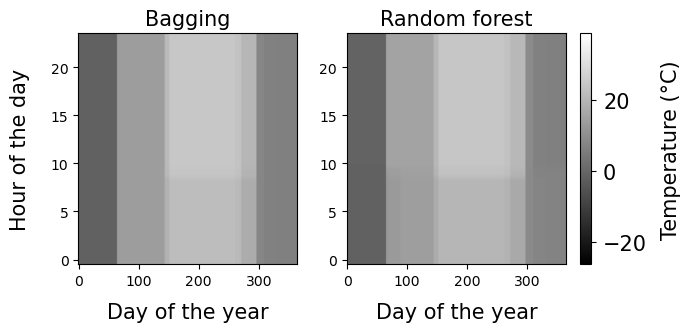

In [14]:
# Find min and max value for plots
max_bagging = np.max(plot_bagging[-1])
max_random_forest = np.max(plot_random_forest[-1])
max_all = np.max(np.array([max_bagging,max_random_forest]))
min_bagging = np.min(plot_bagging[-1])
min_random_forest = np.min(plot_random_forest[-1])
min_all = np.min(np.array([min_bagging,min_random_forest]))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])

ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax1.set_title("Training data",fontsize=font_size);

im = ax2.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax2.set_title("Test data",fontsize=font_size);
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)

fig, (ax3,ax4) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])
ax3.imshow(plot_bagging[-1], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax3.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax3.set_title("Bagging",fontsize=font_size);

im2 = ax4.imshow(plot_random_forest[-1], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
cbar = plt.colorbar(im2)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)
ax4.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax4.set_title("Random forest",fontsize=font_size);

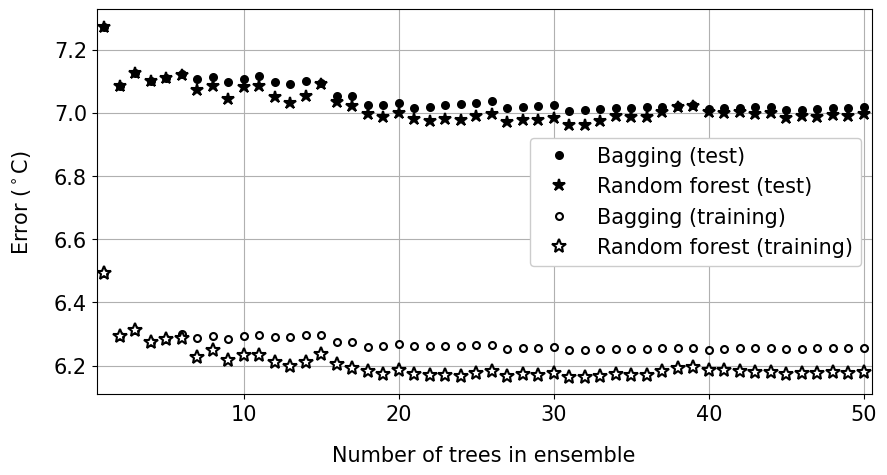

In [15]:
msize=5
medgewidth=1.5
n_trees = np.arange(1,n_bootstrap+1)

plt.figure(figsize=(10,5))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.xlim([0.5,n_bootstrap+0.5])
plt.grid()
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
plt.xlabel(r'Number of trees in ensemble',fontsize=font_size,labelpad = 15)

plt.plot(n_trees,error_2016_bagging,color="black",markersize=msize, 
         marker='o',markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
         label="Bagging (test)")
plt.plot(n_trees,error_2016_random_forest,color="black",markersize=msize+4, 
                 marker='*',markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
                 label="Random forest (test)")
plt.plot(n_trees,error_2015_bagging,color="white",markersize=msize, 
         marker='o', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
         label="Bagging (training)")
plt.plot(n_trees,error_2015_random_forest,color="white",markersize=msize+5, 
                 marker='*', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                 label="Random forest (training)")
plt.legend(fontsize=font_size,loc="center right",framealpha=1);

In [16]:
print("Bagging training error",round(error_2015_bagging[31],3))
print("Bagging test error",round(error_2016_bagging[31],3))
print("Random forest training error",round(error_2015_random_forest[31],3))
print("Random forest error",round(error_2016_random_forest[31],3))

Bagging training error 6.25
Bagging test error 7.008
Random forest training error 6.164
Random forest error 6.962


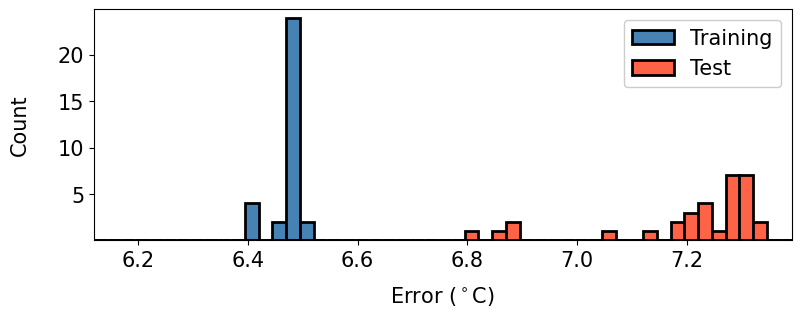

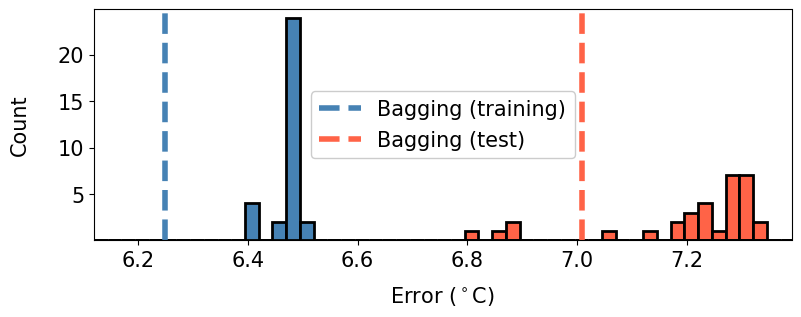

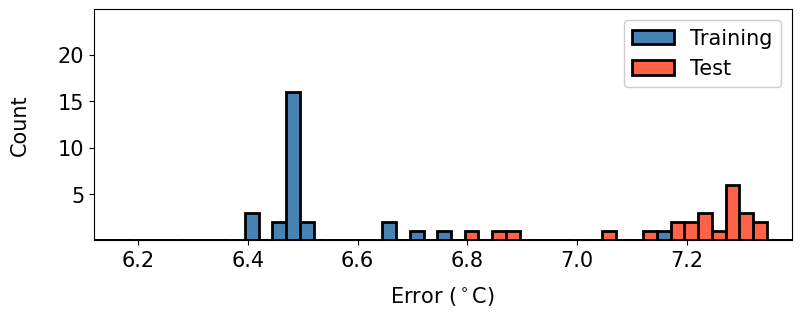

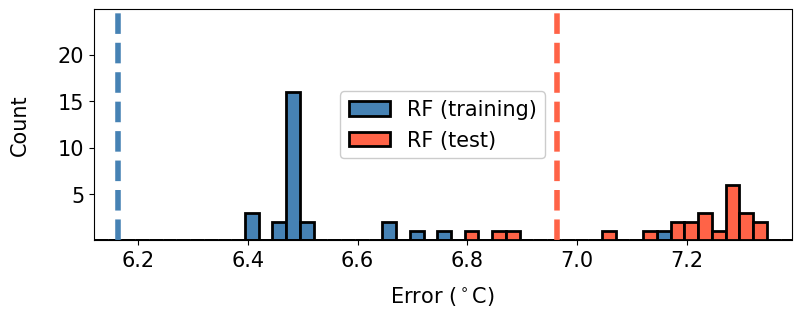

In [17]:
ymin = 0.001
ymax = 24.9
xmin = 6.12
xmax = 7.39
binwidth = 0.025
bin_aux = np.arange(xmin, xmax + binwidth, binwidth)
plt.figure(figsize=(9,3))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.hist(error_2015_bagging_individual[:32],bins=bin_aux,color='steelblue', edgecolor='black',
          linewidth=2,density=False,label="Training")
plt.hist(error_2016_bagging_individual[:32],bins=bin_aux,color='tomato', edgecolor='black',
          linewidth=2,density=False,label="Test")
plt.xlim([xmin,xmax])
plt.ylim([0.001,ymax])
plt.ylabel(r"Count",fontsize=font_size,labelpad=20)
plt.xlabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size,framealpha=1)

plt.figure(figsize=(9,3))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.hist(error_2016_bagging_individual[:32],bins=bin_aux,color='tomato', edgecolor='black',
          linewidth=2,density=False)
plt.xlim([xmin,xmax])
plt.hist(error_2015_bagging_individual[:32],bins=bin_aux,color='steelblue', edgecolor='black',
          linewidth=2,density=False)
plt.ylim([0.001,ymax])
plt.vlines(error_2015_bagging[31],ymin,ymax,lw=4,ls="dashed",color="steelblue",label="Bagging (training)")
plt.vlines(error_2016_bagging[31],ymin,ymax,lw=4,ls="dashed",color="tomato",label="Bagging (test)")
plt.ylabel(r"Count",fontsize=font_size,labelpad=20)
plt.xlabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size,loc="center",framealpha=1)

plt.figure(figsize=(9,3))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.hist(error_2015_rf_individual[:32],bins=bin_aux,color='steelblue', edgecolor='black',
          linewidth=2,density=False,label="Training")
plt.hist(error_2016_rf_individual[:32],bins=bin_aux,color='tomato', edgecolor='black',
          linewidth=2,density=False,label="Test")
plt.xlim([xmin,xmax])
plt.ylim([0.001,ymax])
plt.ylabel(r"Count",fontsize=font_size,labelpad=20)
plt.xlabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size,framealpha=1)

plt.figure(figsize=(9,3))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.xlim([xmin,xmax])
plt.hist(error_2015_rf_individual[:32],bins=bin_aux,color='steelblue', edgecolor='black',
          linewidth=2,density=False,label="RF (training)")
plt.hist(error_2016_rf_individual[:32],bins=bin_aux,color='tomato', edgecolor='black',
          linewidth=2,density=False,label="RF (test)")
plt.ylim([0.001,ymax])
plt.vlines(error_2015_random_forest[31],ymin,ymax,lw=4,ls="dashed",color="steelblue")
plt.vlines(error_2016_random_forest[31],ymin,ymax,lw=4,ls="dashed",color="tomato")
plt.ylabel(r"Count",fontsize=font_size,labelpad=20)
plt.xlabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size,loc="center",framealpha=1);

In [18]:
# Boosting
boosting_constant_vals = [1,0.1]
n_boosting_vals = len(boosting_constant_vals)
n_iter = 50
error_2015_boosting = np.zeros((n_boosting_vals,n_iter))
error_2016_boosting = np.zeros((n_boosting_vals,n_iter))

n_splits = 4

n = len(temperature_2015)

plot_inds = [0,1,3,4,9,14,19,29,35]
plot_trees_boosting = [[],[]]
plot_boosting = [[],[]]

for ind_constant,boosting_constant in enumerate(boosting_constant_vals):
    residual = np.copy(temperature_2015)
    boosting_estimate = 0
    
    for iteration in range(n_iter):
        
        regions = recursive_binary_splitting(residual,day_2015,hour_2015,n_splits,verbose=False)
        estimate = tree_estimate(regions,residual,day_2015,hour_2015)
        boosting_estimate += boosting_constant * estimate
        
        for ind in range(n):
            residual[ind] = residual[ind] - boosting_constant * estimate[hour_2015[ind],day_2015[ind]-1]
                
        error_2015_boosting[ind_constant,iteration] = compute_error(boosting_estimate, temperature_2015,
                                                                    day_2015,hour_2015)
        error_2016_boosting[ind_constant,iteration] = compute_error(boosting_estimate, temperature_2016,
                                                                    day_2016,hour_2016)
        if iteration in plot_inds:
            plot_trees_boosting[ind_constant].append(np.copy(estimate))
            plot_boosting[ind_constant].append(np.copy(boosting_estimate))

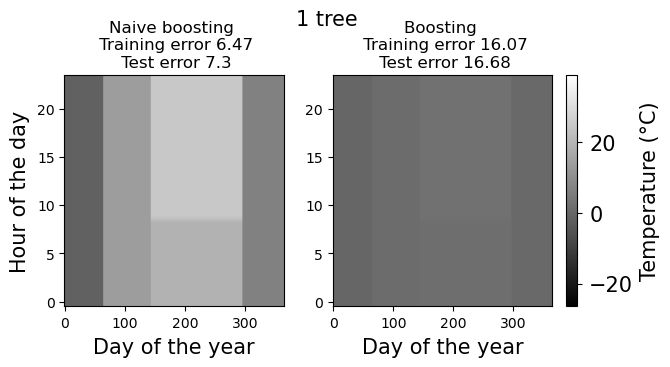

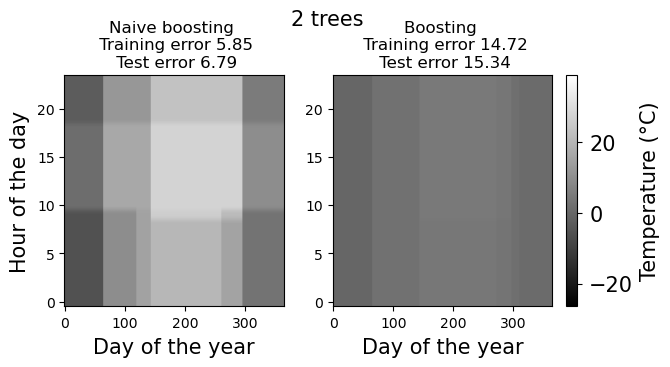

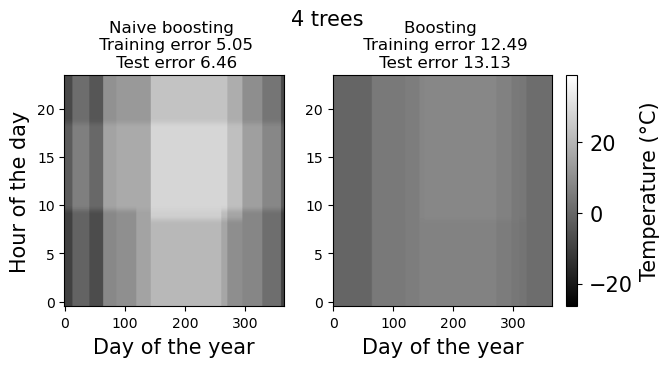

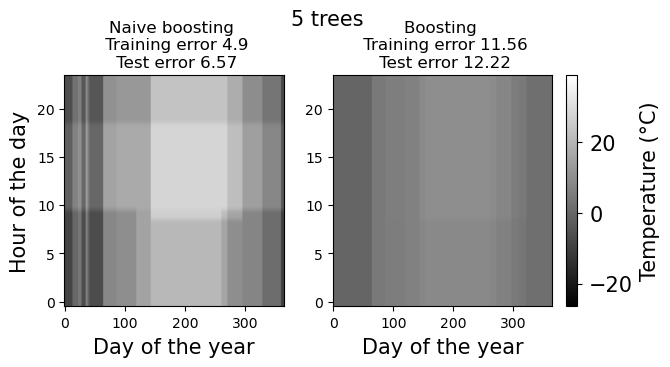

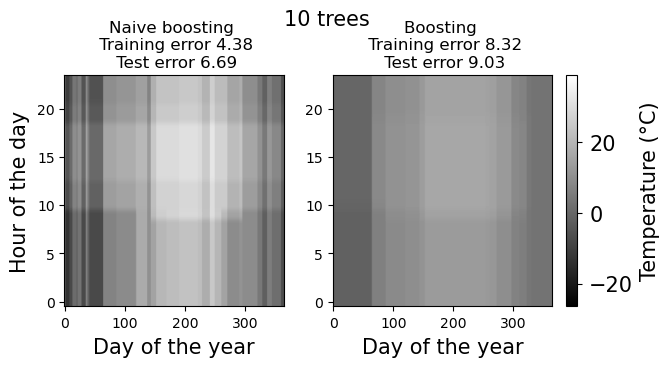

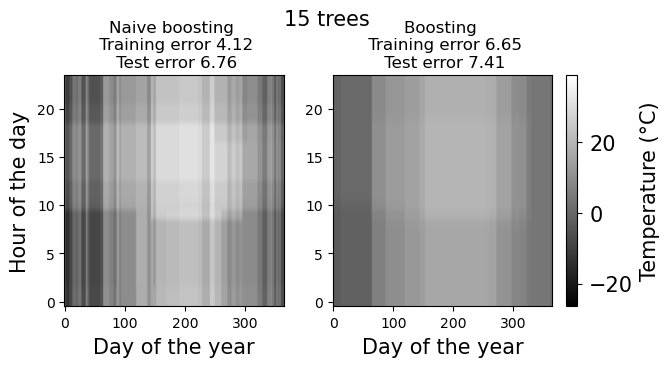

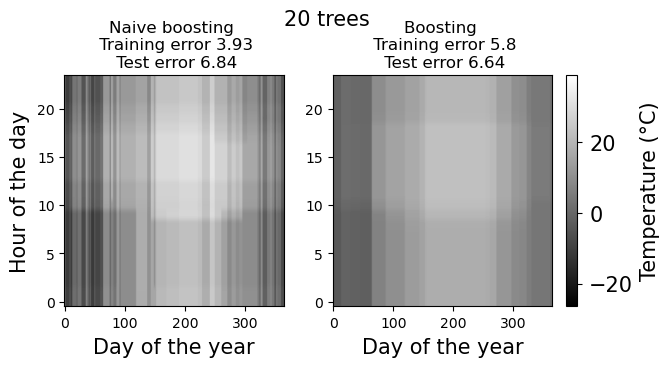

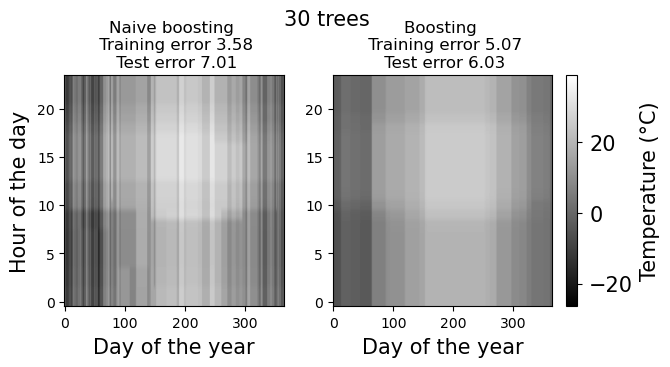

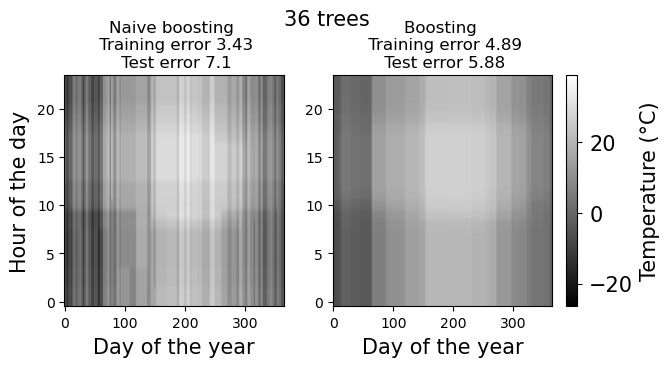

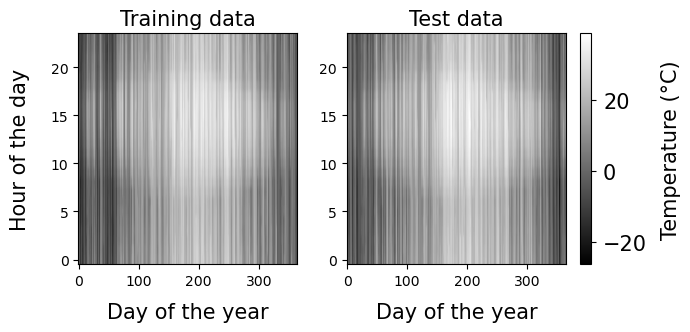

In [19]:
for ind in range(len(plot_inds)):

    ind_plots = plot_inds[ind] 
    
    fig, (ax3,ax4) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])
    
    if ind_plots == 0:
        fig.suptitle("1 tree",fontsize=font_size,y = 1.1)
    else:
        fig.suptitle(str(ind_plots+1) + " trees",fontsize=font_size,y = 1.1)
    
    ax3.imshow(plot_boosting[0][ind], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                        origin='lower', aspect='auto')
    ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 5)
    ax3.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 5)
    ax3.set_title("Naive boosting \n Training error " + str(np.round(error_2015_boosting[0][ind_plots],2))
                  + "\n Test error " + str(np.round(error_2016_boosting[0][ind_plots],2)));
    
    im2 = ax4.imshow(plot_boosting[1][ind], cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                        origin='lower', aspect='auto')
    cbar = plt.colorbar(im2)
    cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
    cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 5)
    ax4.set_xlabel('Day of the year',fontsize=font_size,labelpad = 5)
    ax4.set_title("Boosting \n Training error " + str(np.round(error_2015_boosting[1][ind_plots],2))
                  + "\n Test error " + str(np.round(error_2016_boosting[1][ind_plots],2)));

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,3),width_ratios=[4,5])

ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax1.set_title("Training data",fontsize=font_size);

im = ax2.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax2.set_title("Test data",fontsize=font_size);
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10);

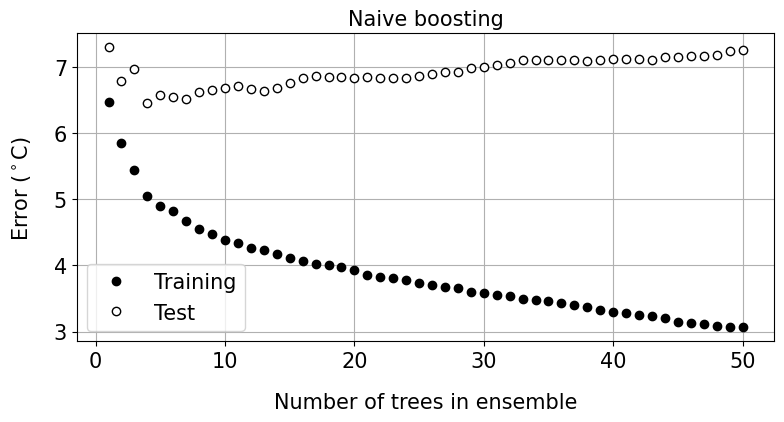

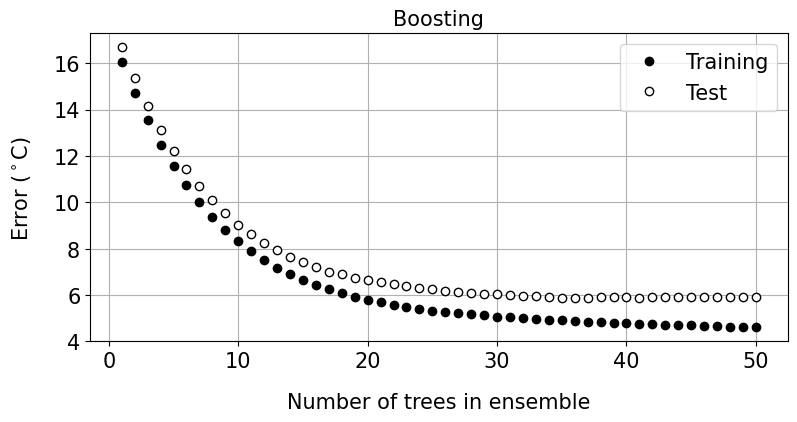

In [20]:
msize=6
medgewidth=1
iterations = np.arange(1,n_iter+1)

for ind_constant,boosting_constant in enumerate(boosting_constant_vals):

    plt.figure(figsize=(9,4))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(iterations,error_2015_boosting[ind_constant,:],color="black",markersize=msize, 
                     marker='o', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label="Training")
    plt.plot(iterations,error_2016_boosting[ind_constant,:],color="white",markersize=msize, 
                     marker='o', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label="Test")
    plt.grid()
    if ind_constant == 0:
        plt.title('Naive boosting',fontsize=font_size)
    else:
        plt.title('Boosting',fontsize=font_size)
    plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
    plt.xlabel(r'Number of trees in ensemble',fontsize=font_size,labelpad = 15)
    plt.legend(fontsize=font_size);

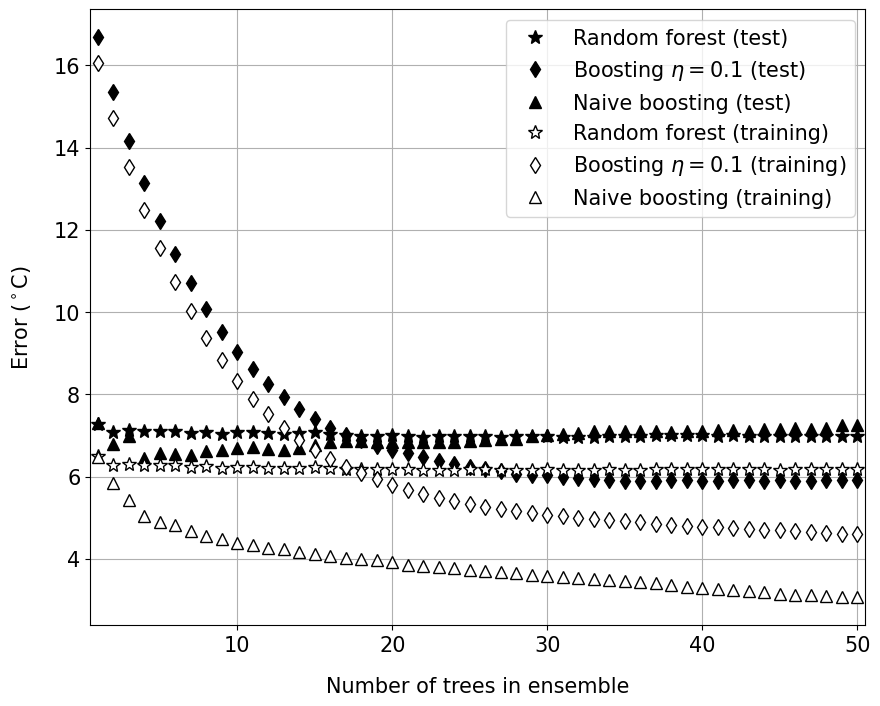

In [22]:
msize=8
medgewidth=1
n_trees = np.arange(1,n_iter+1)

plt.figure(figsize=(10,8))
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.xlim([0.5,n_iter+0.5])
plt.grid()
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
plt.xlabel(r'Number of trees in ensemble',fontsize=font_size,labelpad = 15)

plt.plot(n_trees,error_2016_random_forest,color="black",markersize=msize+2, 
                 marker='*',markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
                 label="Random forest (test)")
plt.plot(n_trees,error_2016_boosting[1,:],color="black",markersize=msize, 
                     marker='d', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label=r"Boosting $\eta = 0.1$ (test)")
plt.plot(n_trees,error_2016_boosting[0,:],color="black",markersize=msize, 
                     marker='^', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label=r"Naive boosting (test)")
plt.plot(n_trees,error_2015_random_forest,color="white",markersize=msize+2, 
                 marker='*', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                 label="Random forest (training)")
plt.plot(n_trees,error_2015_boosting[1,:],color="white",markersize=msize, 
                     marker='d', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label=r"Boosting $\eta = 0.1$ (training)")
plt.plot(n_trees,error_2015_boosting[0,:],color="white",markersize=msize, 
                     marker='^', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                     label=r"Naive boosting (training)")
plt.legend(fontsize=font_size);